<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#План-работ:" data-toc-modified-id="План-работ:-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>План работ:</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод-по-разделу-&quot;Подготовка&quot;" data-toc-modified-id="Вывод-по-разделу-&quot;Подготовка&quot;-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод по разделу "Подготовка"</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Анализ-методом-ресемплирования" data-toc-modified-id="Анализ-методом-ресемплирования-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Анализ методом ресемплирования</a></span></li><li><span><a href="#Анализ-сезонности-методом-seasonal_decompose" data-toc-modified-id="Анализ-сезонности-методом-seasonal_decompose-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Анализ сезонности методом seasonal_decompose</a></span></li><li><span><a href="#Вывод-по-п.-2" data-toc-modified-id="Вывод-по-п.-2-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Вывод по п. 2</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков" data-toc-modified-id="Подготовка-признаков-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Подготовка признаков</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#Дополнительно:-LightGBM---подбор-гиперпараметров-циклом" data-toc-modified-id="Дополнительно:-LightGBM---подбор-гиперпараметров-циклом-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Дополнительно: LightGBM - подбор гиперпараметров циклом</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод-по-исследованию" data-toc-modified-id="Вывод-по-исследованию-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод по исследованию</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Описание данных
Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## План работ:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке.

## Подготовка

In [1]:
# импортируем библиотеки 
import os
import math
import time
import itertools 
import urllib.request
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 8, 4

from pathlib import Path

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

import lightgbm as lgb
from lightgbm import LGBMRegressor

import catboost as cbr
from catboost import CatBoostRegressor

from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [2]:
# создадим класс с набором инструментов, часто используемых в подготовке данных в DataScience
class DataScience:

    # загрузка датасета
    def path_to_files(self, path, link):
        Path('datasets').mkdir(parents=True, exist_ok=True)
        def get_file(file_name, url):
            if not os.path.exists(file_name):
                print(file_name, 'local file not found so link will be downloaded')
                _ = urllib.request.urlretrieve(url, file_name)
        urls = {
            'dataset': (path, link)
        }
        [get_file(*urls[k]) for k in urls]
        data = pd.read_csv(urls['dataset'][0])
        return data

    # построение диаграммы корреляции (тепловая карта)
    def corr_diagram(self, x):
        plt.figure(figsize=(12, 10), dpi=80)
        sns.heatmap(x.corr(), xticklabels=x.corr().columns, yticklabels=x.corr().columns, cmap='RdYlGn', center=0,
                    annot=True)
        plt.title('Диаграмма корреляции', fontsize=22)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    # чистка датасета
    def clean_dataset(self, df):
        assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
        df.dropna(inplace=True)
        indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
        return df[indices_to_keep].astype(np.float64)

    # поиск NaN и нулевых значений
    def missing_zero_values_table(self, df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
            columns={0: 'Zero Values', 1: 'Missing Values', 2: '% of Total Values'})
        mz_table['Total Zero and Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero and Missing Values'] = 100 * mz_table['Total Zero and Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[mz_table.iloc[:, 1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        print("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
           "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.") 
        print("Number of rows that have at least one NaN", df.isnull().any(axis=1).sum(), " or ",  f"{df.isnull().any(axis=1).sum() / len(df):.1%}")        
        return mz_table

    # заполнение пропусков в признаке ('column') значениями по принципу наиболее 
    # распространенных из других указанных групп column1, column2  
    def fill_with_mode(self, column, column1, column2):
        df[column] = df.groupby([column1, column2])[column].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))       


In [3]:
# присвоим переменной ds созданный класс DataScience
ds = DataScience()

In [4]:
# загрузим датасет методом path_to_files из класса DataScience

try:
    df = ds.path_to_files('e:/Яндекс.Практикум/Спринт 15 Временные ряды/data/taxi.csv','https://code.s3.yandex.net/datasets/taxi.csv')
except:
    df = pd.read_csv("/datasets/taxi.csv")

In [5]:
# ознакомимся с датасетом просмотром первых и последних строк
display(df)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [6]:
# ознакомимся с датасетом методом info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [7]:
# ознакомимся с датасетом методом describe
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [8]:
# посчитаем количество дубликатов в датасете - при такой структуре датасета (сумма заказов каждые 10 минут) 
# не должно быть дубликатов, поэтому, если они есть, то необходимо удалить дубликаты
# т.к. два разных 
df.duplicated().sum()

0

13.0

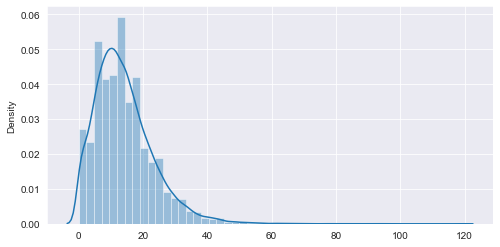

In [9]:
# посмотрим на распределение целевого признака
sns.distplot(df.num_orders.values)
np.median(df.num_orders.values)

В датасете нет пропусков, названия признаков соответствуют PEP-8, датасет содержит 26496 объектов. Тип данных у признака 'num_orders' соответствует логике базы данных. Тип данных в 'datetime' следует привести в соответствие и назначить упорядоченным индексом датасета

In [10]:
# Тип данных в 'datetime' приведем в соответствие и назначим упорядоченным индексом датасета

# установим тип данных 'datetime64' в df['datetime']
df['datetime'] = df['datetime'].astype('datetime64')

# установим индекс таблицы равным столбцу datetime
df = df.set_index('datetime')

# отсортируем по индексу
df = df.sort_index()

# проверим правильность сортировки
print(df.index.is_monotonic)

True


### Вывод по разделу "Подготовка"
    В датасете нет пропусков, названия признаков соответствуют PEP-8, датасет содержит 26496 объектов. Тип данных у признака 'num_orders' соответствует логике базы данных, тип данных в 'datetime' приведен в соответствие (datetime64) и назначен упорядоченным индексом датасета (это намеренно сделано после проверки на дубликаты!). 
    
    Данные подготовлены для дальнейшего анализа

## Анализ

### Анализ методом ресемплирования

In [11]:
# ресемплируем датасет по одному часу, неделе и месяцу
df_resample_monthly = df.resample('1M').sum()
df_resample_weekly = df.resample('1W').sum()
df_resample_hourly = df.resample('1H').sum()

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

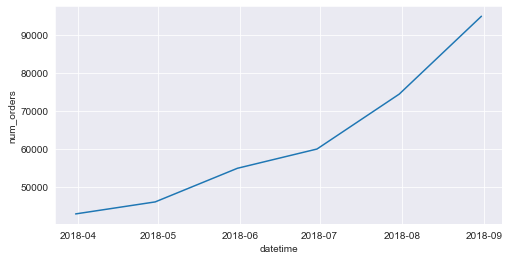

In [12]:
# визуализируем количество заказов по месяцам
sns.lineplot(x=df_resample_monthly.index,y=df_resample_monthly['num_orders'])

<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

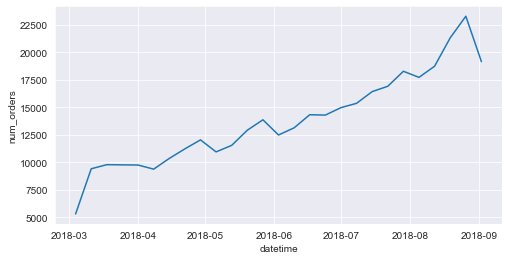

In [13]:
# визуализируем количество заказов по неделям
sns.lineplot(x=df_resample_weekly.index,y=df_resample_weekly['num_orders'])

<AxesSubplot:xlabel='datetime'>

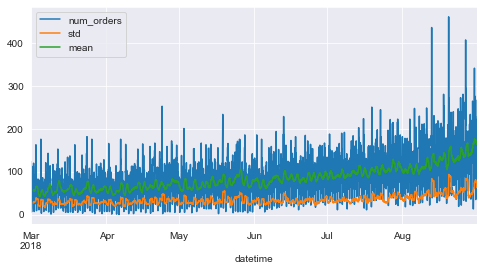

In [14]:
# рассчитаем скользящее стандартное отклонение для визаулизации на графике
df_resample_hourly['std'] = df_resample_hourly['num_orders'].rolling(24).std()

# рассчитаем скользящее среднее для визаулизации на графике
df_resample_hourly['mean'] = df_resample_hourly['num_orders'].rolling(24).mean()

# визуализируем количество заказов по часам и рассчитанные скользящее стандартное отклонение и скользящее среднее
df_resample_hourly.plot()

Видно, что количество заказов растет в течение года, что подтверждают скользящее среднее и скользящее стандартное отклонение

### Анализ сезонности методом seasonal_decompose

In [15]:
# проведем анализ сезонности, для чего в новую переменную поместим датасет и снова ресемплируем по часу
df_for_analisis = df
df_for_analisis = df_for_analisis.resample('1H').sum()
df_for_analisis = df_for_analisis.dropna()

Text(0.5, 1.0, 'Seasonality 2 days')

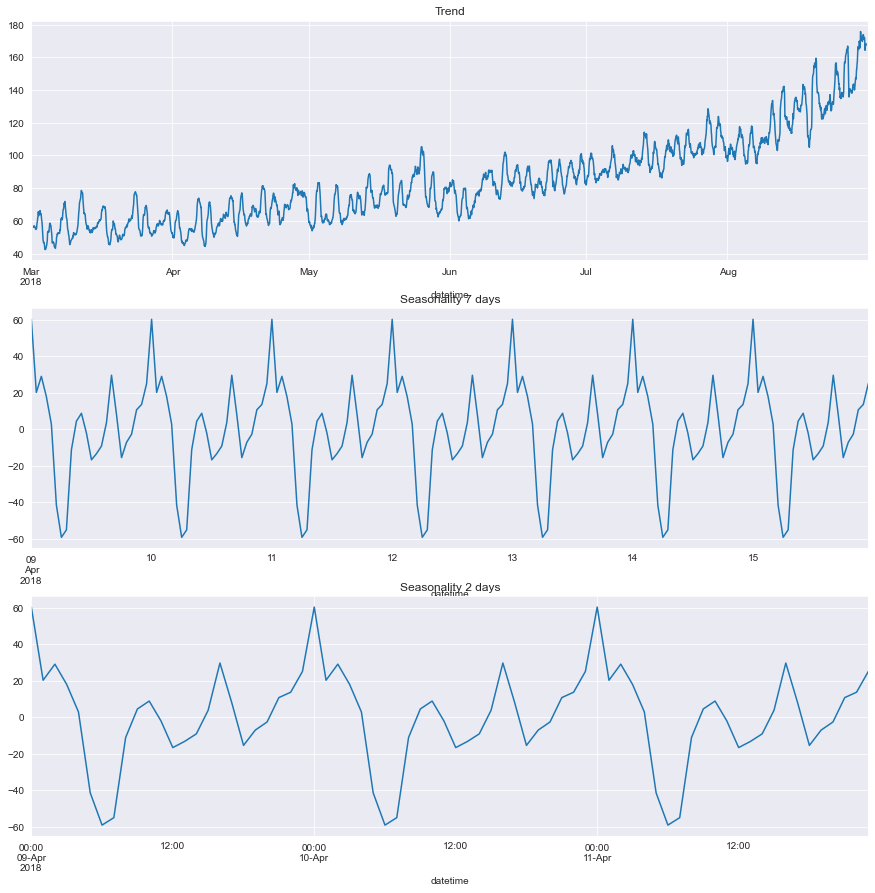

In [16]:
# построим график для общего тренда
decomposed = seasonal_decompose(df_for_analisis)  # < напишите код здесь >

plt.figure(figsize=(15, 15))

#строим график для тренда
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его оси ax, равными plt.gca() (англ. get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

#строим график для сезонности по дням одной недели (взята одна случайная непраздничная неделя)
plt.subplot(312)
decomposed.seasonal['2018-04-09':'2018-04-15'].plot(ax=plt.gca())
plt.title('Seasonality 7 days')

#строим график для сезонности в течение дня из случайной недели
plt.subplot(313)
decomposed.seasonal['2018-04-09':'2018-04-11'].plot(ax=plt.gca())
plt.title('Seasonality 2 days')

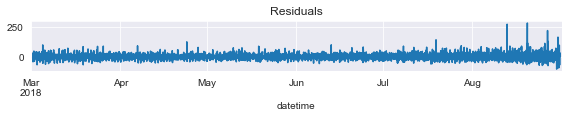

In [17]:
# посмотрим "шум"
plt.subplot(311)
decomposed.resid.plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Residuals')
plt.tight_layout()

### Вывод по п. 2

    При анализе методом "seasonal_decompose" выявлены следующие особенности:
        выявлен восходящий тренд количества заказов с марта по август 2018 года включительно
        выявлена сезонность в количестве заказов в течение дня: в 4-5 утра количество заказов минимальное, затем первый пик в 11 часов, второй пик приходится на 15 часов, третий пик - в полночь

## Обучение

### Подготовка признаков

In [18]:
# подготовим новый датафрейм с признаками со смещением

# сделаем ресемплирование по одному часу
df_for_ml = df.resample('1H').sum()

# напишем функцию для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek
           
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df_for_ml, 7, 7)
display(df_for_ml)

,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.428571
2018-08-31 20:00:00,154,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,167.428571
2018-08-31 21:00:00,159,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,165.714286


In [19]:
# разделим датасет на обучающую (90%) и тестовую (10%) выборки
train, test = train_test_split(df_for_ml, shuffle=False, test_size=0.1)
train = train.dropna()

In [20]:
# определим признаки и целевой признак у обучающей и тестовой выборк
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'],axis=1)
target_test = test['num_orders']

In [21]:
# проверим, что временные ряды в выборках упорядочены
display(train)
display(test)

,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 07:00:00,15,7,3,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.142857
2018-03-01 08:00:00,34,8,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0,42.571429
2018-03-01 09:00:00,69,9,3,34.0,15.0,12.0,6.0,43.0,66.0,71.0,35.285714
2018-03-01 10:00:00,64,10,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,35.000000
2018-03-01 11:00:00,96,11,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,34.714286
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,9,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,146.714286
2018-08-13 10:00:00,156,10,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,103.857143
2018-08-13 11:00:00,144,11,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,102.142857


,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,
2018-08-13 14:00:00,102,14,0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,111.142857
2018-08-13 15:00:00,175,15,0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,120.142857
2018-08-13 16:00:00,144,16,0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,132.142857
2018-08-13 17:00:00,152,17,0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,133.142857
2018-08-13 18:00:00,104,18,0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,132.571429
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.428571
2018-08-31 20:00:00,154,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,167.428571
2018-08-31 21:00:00,159,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,165.714286


In [22]:
# посмотрим размеры обучающей и тестовой выборки
print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], features_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], features_test.shape[1]))

Размер обучающей выборки: 3967 объектов, 10 признаков
Размер тестовой выборки: 442 объектов, 10 признаков


In [23]:
# создадим функцию для расчета RMSE
def RMSE (predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### LinearRegression

Обучим, получим предсказания и проверим качество модели LinearRegression 

In [24]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(n_jobs=-1)
lr.fit(features_train, target_train)
lr_predictions = lr.predict(features_test)
print('RMSE =', RMSE(lr_predictions, target_test))

RMSE = 54.26360813472962


### CatBoostRegressor

 Обучим, получим предсказания и проверим качество модели CatBoostRegressor с замером времени. Официальный сайт - https://catboost.ai/ 
 Ознакомительная статья по данной модели размещена по ссылке https://itnan.ru/post.php?c=1&p=594077
    
    CatBoost – библиотека, которая была разработана Яндексом в 2017 году, представляет разновидность семейства алгоритмов Boosting и является усовершенствованной реализацией Gradient Boosting Decision Trees (GBDT). CatBoost имеет поддержку категориальных переменных и обеспечивает высокую точность. Стоит сказать, что CatBoost решает проблему смещения градиента (Gradient Bias) и смещения предсказания (Prediction Shift), это позволяет уменьшить вероятность переобучения и повысить точность алгоритма.

In [25]:
# подберем параметры с помощью GridSearch

# используем TimeSeriesSplit для сохранения порядка временного ряда при кросс-валидации 
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
ts_cv = TimeSeriesSplit(
    n_splits=4,
    gap=10,
    max_train_size=10000,
    test_size=500,
)

model_CBR = CatBoostRegressor()

parameters = {'depth'         : [5, 10],
              'learning_rate' : [0.3, 0.4],
              'iterations'    : [150, 200]
              }

grid = GridSearchCV(estimator=model_CBR, param_grid = parameters, cv = ts_cv, n_jobs=-1, scoring='neg_root_mean_squared_error')
grid.fit(features_train, target_train)

print(" --------------------------------------------------------------------------" )
print(" --------------------------------------------------------------------------" )
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

0:	learn: 33.4380345	total: 149ms	remaining: 22.2s
1:	learn: 30.5169136	total: 152ms	remaining: 11.2s
2:	learn: 28.6848017	total: 154ms	remaining: 7.57s
3:	learn: 27.4251980	total: 157ms	remaining: 5.74s
4:	learn: 26.4625091	total: 160ms	remaining: 4.63s
5:	learn: 25.8693407	total: 163ms	remaining: 3.9s
6:	learn: 25.3902302	total: 165ms	remaining: 3.38s
7:	learn: 25.1057964	total: 168ms	remaining: 2.98s
8:	learn: 24.9079689	total: 171ms	remaining: 2.67s
9:	learn: 24.6941449	total: 173ms	remaining: 2.42s
10:	learn: 24.6344179	total: 176ms	remaining: 2.22s
11:	learn: 24.5753966	total: 178ms	remaining: 2.05s
12:	learn: 24.4079716	total: 181ms	remaining: 1.91s
13:	learn: 24.3448949	total: 183ms	remaining: 1.78s
14:	learn: 24.1682927	total: 186ms	remaining: 1.67s
15:	learn: 23.8626658	total: 189ms	remaining: 1.58s
16:	learn: 23.6446861	total: 191ms	remaining: 1.5s
17:	learn: 23.6169141	total: 194ms	remaining: 1.42s
18:	learn: 23.2975234	total: 197ms	remaining: 1.36s
19:	learn: 23.1484700	to

In [26]:
# применим полученные лучшие параметры
#cat_model_selected_options = CatBoostRegressor(loss_function="RMSE", depth=5, iterations=200,  learning_rate=0.3, verbose=10)
cat_model_selected_options = CatBoostRegressor(loss_function="RMSE", depth=5, iterations=150,  learning_rate=0.3, verbose=10)

In [27]:
%%time
cat_model_selected_options.fit(features_train, target_train)

0:	learn: 33.4380345	total: 19.2ms	remaining: 2.85s
10:	learn: 24.6344179	total: 44.6ms	remaining: 564ms
20:	learn: 23.0860331	total: 71.7ms	remaining: 441ms
30:	learn: 22.1463995	total: 100ms	remaining: 384ms
40:	learn: 21.3066500	total: 127ms	remaining: 337ms
50:	learn: 20.5190742	total: 152ms	remaining: 296ms
60:	learn: 19.8266778	total: 178ms	remaining: 260ms
70:	learn: 19.3150663	total: 207ms	remaining: 230ms
80:	learn: 18.7863334	total: 236ms	remaining: 201ms
90:	learn: 18.3930244	total: 266ms	remaining: 172ms
100:	learn: 18.0604730	total: 294ms	remaining: 143ms
110:	learn: 17.6548181	total: 321ms	remaining: 113ms
120:	learn: 17.3701671	total: 348ms	remaining: 83.4ms
130:	learn: 17.0734584	total: 374ms	remaining: 54.3ms
140:	learn: 16.7046605	total: 402ms	remaining: 25.7ms
149:	learn: 16.4843757	total: 425ms	remaining: 0us
Wall time: 493 ms


In [28]:
%%time
#predicted_cat_selected_options = pd.Series(cat_model_selected_options.predict(features_test))
predicted_cat_selected_options = cat_model_selected_options.predict(features_test)

Wall time: 3 ms


In [29]:
rmse = mean_squared_error(target_test, predicted_cat_selected_options, squared=False)
print("RMSE = ", rmse)

RMSE =  45.52566649717807


### LightGBM

Обучим, получим предсказания и проверим качество модели LightGBM с замером времени

LightGBM, сокращение от Light Gradient Boosting Machine, представляет собой бесплатную распределенную структуру повышения градиента с открытым исходным кодом для машинного обучения, первоначально разработанную Microsoft.

Официальная страница https://lightgbm.readthedocs.io/en/v3.3.2/

In [30]:
# подберем параметры с помощью GridSearch

params = {
    'num_leaves': [2,4,7,9],
    'learning_rate': [0.1, 0.03],
    'max_depth': [3, 5],
    'n_estimators': [100,150,200,250],
}

# используем TimeSeriesSplit для сохранения порядка временного ряда при кросс-валидации 
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
ts_cv = TimeSeriesSplit(
    n_splits=4,
    gap=10,
    max_train_size=10000,
    test_size=500,
)

grid = GridSearchCV(lgb.LGBMRegressor(random_state=0), params, scoring='neg_root_mean_squared_error', cv=ts_cv)
grid.fit(features_train, target_train)

reg = lgb.LGBMRegressor(random_state=0)
reg.fit(features_train, target_train)

print(" --------------------------------------------------------------------------" )
print(" --------------------------------------------------------------------------" )
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

 --------------------------------------------------------------------------
 --------------------------------------------------------------------------
 Results from Grid Search 

 The best estimator across ALL searched params:
 LGBMRegressor(max_depth=5, n_estimators=150, num_leaves=9, random_state=0)

 The best score across ALL searched params:
 -27.280436089291477

 The best parameters across ALL searched params:
 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'num_leaves': 9}


In [31]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 5, 
    'learning_rate': 0.1,
    'n_estimators': 150,
    'num_leaves': 9,
    'verbose': 0
}

In [32]:
lgbm_model = LGBMRegressor(**params)

In [33]:
%%time
lgbm_model.fit(features_train, target_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Wall time:

LGBMRegressor(max_depth=5, metric='rmse', n_estimators=150, num_leaves=9,
              objective='regression', verbose=0)

In [34]:
%%time
predictions_lgbm = lgbm_model.predict(features_test)

Wall time: 4 ms


In [35]:
rmse = mean_squared_error(target_test, predictions_lgbm, squared=False)
print("RMSE = ", rmse)

RMSE =  46.62920144160249


### Дополнительно: LightGBM - подбор гиперпараметров циклом

In [36]:
# разделим датасет на обучающую (90%) и тестовую (10%) выборки
train_c, test_c = train_test_split(df_for_ml, shuffle=False, test_size=0.1)
train_c = train_c.dropna()

In [37]:
# выделим валидационную (50% от train) выборку
train_c, valid_c = train_test_split(train_c, shuffle=False, test_size=0.5)

In [38]:
# определим признаки и целевой признак у обучающей, валидационной и тестовой выборок
features_train_c = train_c.drop(['num_orders'], axis=1)
target_train_c = train_c['num_orders']
features_valid_c = valid_c.drop(['num_orders'],axis=1)
target_valid_c = valid_c['num_orders']
features_test_c = test_c.drop(['num_orders'],axis=1)
target_test_c = test_c['num_orders']

In [39]:
# проверим, что временные ряды в выборках упорядочены
display(train_c)
display(valid_c)
display(test_c)

,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 07:00:00,15,7,3,12.0,6.0,43.0,66.0,71.0,85.0,124.0,58.142857
2018-03-01 08:00:00,34,8,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0,42.571429
2018-03-01 09:00:00,69,9,3,34.0,15.0,12.0,6.0,43.0,66.0,71.0,35.285714
2018-03-01 10:00:00,64,10,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,35.000000
2018-03-01 11:00:00,96,11,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,34.714286
...,...,...,...,...,...,...,...,...,...,...,...
2018-05-22 17:00:00,64,17,1,124.0,60.0,62.0,66.0,55.0,77.0,95.0,77.000000
2018-05-22 18:00:00,44,18,1,64.0,124.0,60.0,62.0,66.0,55.0,77.0,72.571429
2018-05-22 19:00:00,76,19,1,44.0,64.0,124.0,60.0,62.0,66.0,55.0,67.857143


,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,
2018-05-22 22:00:00,95,22,1,77.0,77.0,76.0,44.0,64.0,124.0,60.0,74.571429
2018-05-22 23:00:00,107,23,1,95.0,77.0,77.0,76.0,44.0,64.0,124.0,79.571429
2018-05-23 00:00:00,102,0,2,107.0,95.0,77.0,77.0,76.0,44.0,64.0,77.142857
2018-05-23 01:00:00,120,1,2,102.0,107.0,95.0,77.0,77.0,76.0,44.0,82.571429
2018-05-23 02:00:00,139,2,2,120.0,102.0,107.0,95.0,77.0,77.0,76.0,93.428571
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,9,0,91.0,39.0,66.0,83.0,143.0,168.0,437.0,146.714286
2018-08-13 10:00:00,156,10,0,137.0,91.0,39.0,66.0,83.0,143.0,168.0,103.857143
2018-08-13 11:00:00,144,11,0,156.0,137.0,91.0,39.0,66.0,83.0,143.0,102.142857


,num_orders,hour,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,
2018-08-13 14:00:00,102,14,0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,111.142857
2018-08-13 15:00:00,175,15,0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,120.142857
2018-08-13 16:00:00,144,16,0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,132.142857
2018-08-13 17:00:00,152,17,0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,133.142857
2018-08-13 18:00:00,104,18,0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,132.571429
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.428571
2018-08-31 20:00:00,154,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,167.428571
2018-08-31 21:00:00,159,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,165.714286


In [40]:
# подберем параметры циклом
estimators = [200,250,300,200,250,300,200]
list_for_leaves = [2,4,7,3,5,8,10]
learning_rate = [0.1, 0.2, 0.1, 0.2, 0.1, 0.2, 0.1]


for estim, leaves, learning_rate in zip(estimators, list_for_leaves, learning_rate):
    lgbm_model = lgb.LGBMRegressor(n_estimators=estim, num_leaves=leaves, learning_rate= learning_rate)
    lgbm_model.fit(features_train_c, target_train_c)
    predictions_lgbm_cycle = lgbm_model.predict(features_valid_c)
    print('RMSE with n_estimators : {} and num_leaves: {} and learning_rate: {} = {}'.format(estim, leaves, learning_rate, mean_squared_error(target_valid_c, predictions_lgbm_cycle, squared=False)))

RMSE with n_estimators : 200 and num_leaves: 2 and learning_rate: 0.1 = 34.35204548872654
RMSE with n_estimators : 250 and num_leaves: 4 and learning_rate: 0.2 = 32.12323183584951
RMSE with n_estimators : 300 and num_leaves: 7 and learning_rate: 0.1 = 31.881597818505135
RMSE with n_estimators : 200 and num_leaves: 3 and learning_rate: 0.2 = 30.895068105498456
RMSE with n_estimators : 250 and num_leaves: 5 and learning_rate: 0.1 = 31.737235717043472
RMSE with n_estimators : 300 and num_leaves: 8 and learning_rate: 0.2 = 33.76883431544955
RMSE with n_estimators : 200 and num_leaves: 10 and learning_rate: 0.1 = 32.74579586544136


In [41]:
params_c = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 10, 
    'learning_rate': 0.2,
    'n_estimators': 200,
    'num_leaves': 3,
    'verbose': 0
}

In [42]:
lgbm_model_c = LGBMRegressor(**params_c)

In [43]:
%%time
lgbm_model_c.fit(features_train, target_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
Wall time: 162 ms


LGBMRegressor(learning_rate=0.2, max_depth=10, metric='rmse', n_estimators=200,
              num_leaves=3, objective='regression', verbose=0)

In [44]:
%%time
predictions_lgbm_c = lgbm_model_c.predict(features_test)

Wall time: 4 ms


In [45]:
rmse = mean_squared_error(target_test, predictions_lgbm_c, squared=False)
print("RMSE = ", rmse)

RMSE =  45.566168550892975


## Тестирование

Для наглядного тестирования будет достаточно наложить график реального количества заказов (target_test) на график лучшего предсказанного количества заказов (predictions_lgbm). По условию проекта RMSE создаваемой модели должно быть не больше 48, этому условию соответствуют 2 модели: CatBoostRegressor (RMSE=45.53, время обучения=469ms, время предсказания=3ms) и LightGBM (RMSE=45.57, время обучения=163ms, время предсказания=3.99ms). RMSE у данных моделей практически одинаковая, но выберем CatBoostRegressor, потому что скорость предсказания у нее выше, а именно эта характеристика важна для бизнеса, т.к. обучение будем проводить редко, а предсказывать модель будет постоянно!

<AxesSubplot:xlabel='datetime'>

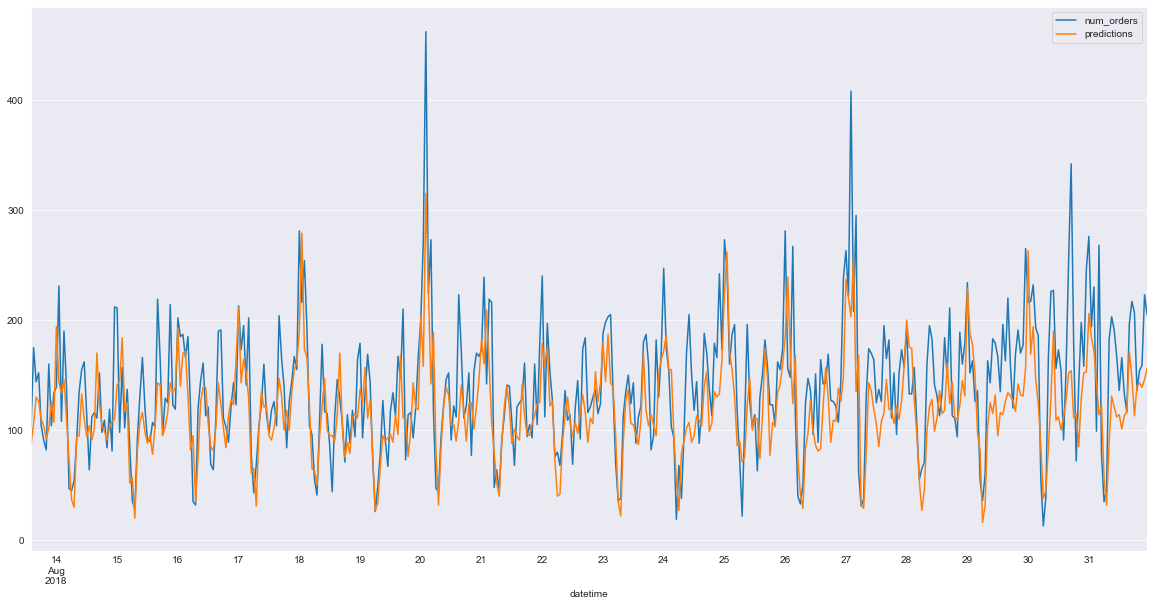

In [46]:
# наложим график реального количества заказов (target_test) на график 
# лучшего предсказанного количества заказов (predictions_lgbm). 

df_predictions_taxi = pd.DataFrame(data = predicted_cat_selected_options, columns = ['predictions'], index = features_test.index.copy())
df_total = pd.merge(target_test, df_predictions_taxi, how = 'left', left_index = True, right_index = True)
df_total['predictions'] = df_total['predictions'].astype('int64')
df_total['2018-03-01':'2018-08-31'].plot(figsize=(20,10))

По построенному графику видно, что в целом модель в достаточной мере предсказывает минимальное количество заказов, а также справляется с предсказанием среднестатистических дней, но может существенно ошибаеться при предсказании пиковых нагрузок в отдельные выбивающиеся дни. Возможно, в эти дни были какие-то события, которые заранее предсказать невозможно, например, крупные спортивные события или концерты знаменитых рок-групп, кинофестивали и т.п. (туристы в отличие от местных жителей могут чаще использовать такси ввиду незнания города и желания его посмотреть из окна такси).

## Вывод по исследованию

**Цель исследования, а именно построение модели, которая способна предсказывать количество заказов такси на следующий час для привлечения большего числа водителей в период пиковой нагрузки, достигнута. Основное условие - значение метрики *RMSE* на тестовой выборке должно быть не больше 48 - выполнено.**

**Обученная модель имеет следующие характеристики:
    CatBoostRegressor(loss_function="RMSE", depth=5, iterations=150,  learning_rate=0.3, verbose=10)
    RMSE=45.53, 
    время обучения=469ms, 
    время предсказания=3ms**

**По построенному графику, на котором отражены предсказания модели и фактические данные по тестовой выборке, видно, что в целом модель в достаточной мере предсказывает минимальное количество заказов, а также справляется с предсказанием среднестатистических дней, но может существенно ошибаеться при предсказании пиковых нагрузок в отдельные выбивающиеся дни. Возможно, в эти дни были какие-то события, которые заранее предсказать невозможно, например, крупные спортивные события или концерты знаменитых рок-групп, кинофестивали и т.п. (туристы в отличие от местных жителей могут чаще использовать такси ввиду незнания города и желания его посмотреть из окна такси).**